In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [125]:
# Load the data from L1_8000rpm_data/ folder
X_train = pd.read_csv('8000rpm_data_z-score/train_sample_fft_scaled.csv').values
X_test = pd.read_csv('8000rpm_data_z-score/test_sample_fft_scaled.csv').values
y_train = pd.read_csv('8000rpm_data_z-score/train_label.csv').values
y_test = pd.read_csv('8000rpm_data_z-score/test_label.csv').values

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [127]:
# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [348]:
# Improved CNN model
dropout_rate = 0.5
kernel_size = 3
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # self.conv16 = nn.Conv1d(1, 16, kernel_size=kernel_size)
        # self.batch_norm16 = nn.BatchNorm1d(16)
        # self.relu16 = nn.ReLU()
        # self.pool16 = nn.MaxPool1d(kernel_size=2)

        self.conv32 = nn.Conv1d(1, 32, kernel_size=kernel_size)
        self.batch_norm32 = nn.BatchNorm1d(32)
        self.relu32 = nn.ReLU()
        self.pool32 = nn.MaxPool1d(kernel_size=2)
        
        self.conv64 = nn.Conv1d(32, 64, kernel_size=kernel_size)
        self.batch_norm64 = nn.BatchNorm1d(64)
        self.relu64 = nn.ReLU()
        self.pool64 = nn.MaxPool1d(kernel_size=2)

        self.conv128 = nn.Conv1d(64, 128, kernel_size=kernel_size)
        self.batch_norm128 = nn.BatchNorm1d(128)
        self.relu128 = nn.ReLU()
        self.pool128 = nn.MaxPool1d(kernel_size=2)

        self.conv256 = nn.Conv1d(128, 256, kernel_size=kernel_size)
        self.batch_norm256 = nn.BatchNorm1d(256)
        self.relu256 = nn.ReLU()
        self.pool256 = nn.MaxPool1d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * (65-kernel_size), 1024)  # Adjust based on new dimensions
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(1024, 256)
        self.relu2 = nn.ReLU()
        # self.fc3 = nn.Linear(512, 256)
        # self.relu3 = nn.ReLU()
        # self.fc4 = nn.Linear(256, 128)
        # self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(256, 32)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(32, 9)

    def forward(self, x):
        # x = self.batch_norm16(self.relu16(self.conv16(x)))
        # x = self.pool16(x)
        x = self.batch_norm32(self.relu32(self.conv32(x)))
        x = self.pool32(x)
        x = self.batch_norm64(self.relu64(self.conv64(x)))
        x = self.pool64(x)
        x = self.batch_norm128(self.relu128(self.conv128(x)))
        x = self.pool128(x)
        x = self.batch_norm256(self.relu256(self.conv256(x)))
        x = self.pool256(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        # x = self.fc3(x)
        # x = self.relu3(x)
        # x = self.dropout(x)
        # x = self.fc4(x)
        # x = self.relu4(x)
        # x = self.dropout(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.dropout(x)
        x = self.fc6(x)
        return x

In [351]:
# Instantiate model, loss, and optimizer
learning_rate = 0.00003
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [352]:
# Train the model
num_epochs = 50
history = {'loss': [], 'accuracy': [], 'val_accuracy': []}
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.argmax(dim=1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels.argmax(dim=1)).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_accuracy)
    
    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    val_total = 0
    with torch.no_grad():  # No need to compute gradients for validation
        for inputs, labels in test_loader:  # Assuming you have a validation data loader
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels.argmax(dim=1)).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    history['val_accuracy'].append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 1.9883, Accuracy: 0.2567, Validation Accuracy: 0.4733
Epoch 2/50, Loss: 1.6899, Accuracy: 0.3717, Validation Accuracy: 0.5644
Epoch 3/50, Loss: 1.4999, Accuracy: 0.4456, Validation Accuracy: 0.6467
Epoch 4/50, Loss: 1.3614, Accuracy: 0.4939, Validation Accuracy: 0.7311
Epoch 5/50, Loss: 1.2263, Accuracy: 0.5478, Validation Accuracy: 0.7644
Epoch 6/50, Loss: 1.1372, Accuracy: 0.5867, Validation Accuracy: 0.8200
Epoch 7/50, Loss: 1.0381, Accuracy: 0.6150, Validation Accuracy: 0.8222
Epoch 8/50, Loss: 0.9375, Accuracy: 0.6622, Validation Accuracy: 0.8333
Epoch 9/50, Loss: 0.8463, Accuracy: 0.7017, Validation Accuracy: 0.8644
Epoch 10/50, Loss: 0.7764, Accuracy: 0.7233, Validation Accuracy: 0.8778
Epoch 11/50, Loss: 0.7177, Accuracy: 0.7389, Validation Accuracy: 0.8844
Epoch 12/50, Loss: 0.6515, Accuracy: 0.7700, Validation Accuracy: 0.9133
Epoch 13/50, Loss: 0.5994, Accuracy: 0.7906, Validation Accuracy: 0.8956
Epoch 14/50, Loss: 0.5242, Accuracy: 0.8233, Validation Accu

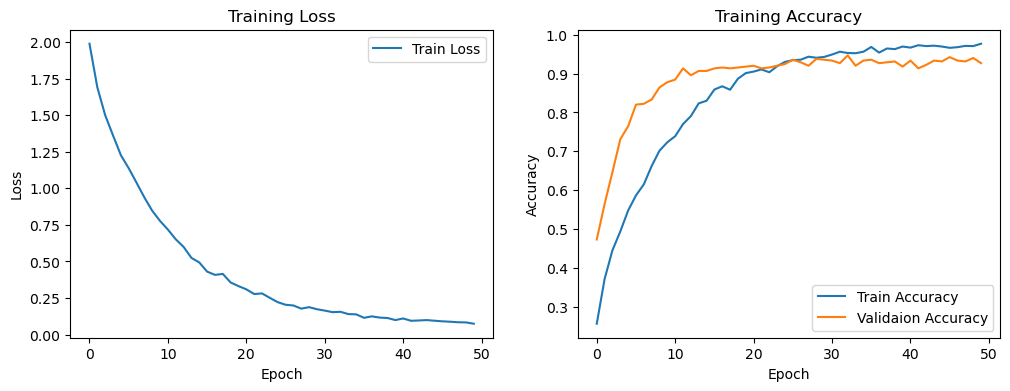

In [353]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validaion Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')

plt.savefig(f"./images/train_lr{learning_rate}_dr{dropout_rate}.png")
plt.show()

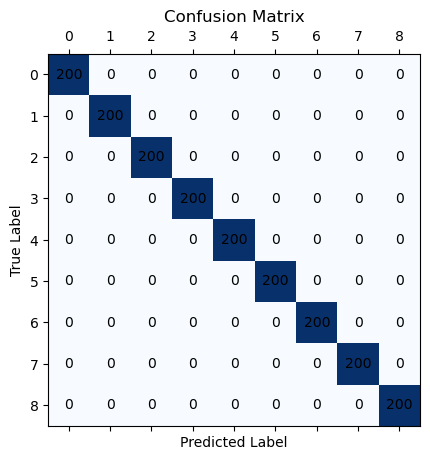

In [355]:
from sklearn.metrics import confusion_matrix

# 模型预测
y_pred_train = model(X_train)

y_pred_classes = np.argmax(y_pred_train.cpu().detach().numpy(), axis=1)
y_train_classes = np.argmax(y_train.cpu().detach().numpy(), axis=1)

# 计算混淆矩阵
conf_mat = confusion_matrix(y_train_classes, y_pred_classes)

# 绘制混淆矩阵
plt.matshow(conf_mat, cmap='Blues')
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

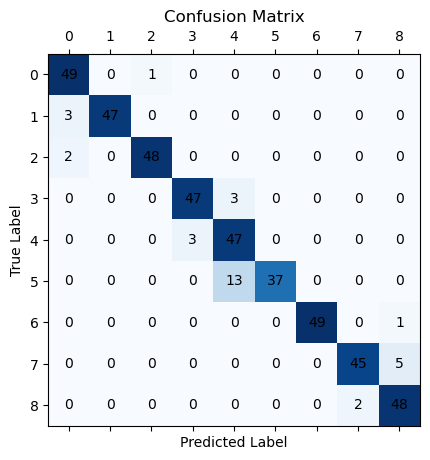

In [357]:
from sklearn.metrics import confusion_matrix

# 模型预测
y_pred = model(X_test)

y_pred_classes = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
y_test_classes = np.argmax(y_test.cpu().detach().numpy(), axis=1)

# 计算混淆矩阵
conf_mat = confusion_matrix(y_test_classes, y_pred_classes)

# 绘制混淆矩阵
plt.matshow(conf_mat, cmap='Blues')
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [358]:
from sklearn.metrics import classification_report

# 评估
print("Classification Report:")
print(classification_report(y_pred=y_pred_classes, y_true=y_test_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        50
           1       1.00      0.94      0.97        50
           2       0.98      0.96      0.97        50
           3       0.94      0.94      0.94        50
           4       0.75      0.94      0.83        50
           5       1.00      0.74      0.85        50
           6       1.00      0.98      0.99        50
           7       0.96      0.90      0.93        50
           8       0.89      0.96      0.92        50

    accuracy                           0.93       450
   macro avg       0.94      0.93      0.93       450
weighted avg       0.94      0.93      0.93       450

